## Data Preparation

In [ ]:
!unzip /content/drive/MyDrive/dataset_final/dataset_splits.zip -d /content/dataset_split_final

Archive:  /content/drive/MyDrive/dataset_final/dataset_splits.zip
   creating: /content/dataset_split_final/dataset_splits/
   creating: /content/dataset_split_final/dataset_splits/test/
   creating: /content/dataset_split_final/dataset_splits/test/annotations/
  inflating: /content/dataset_split_final/dataset_splits/test/annotations/test_annotations.jsonl  
   creating: /content/dataset_split_final/dataset_splits/test/images/
  inflating: /content/dataset_split_final/dataset_splits/test/images/1001.png  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1030.png  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1033.jpg  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1036.png  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1039.png  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1043.png  
  inflating: /content/dataset_split_final/dataset_splits/test/images/1047.png  
  inflati

In [ ]:
!find /content/dataset_split_final/dataset_splits/test -type f -name "*.png" -o -name "*.jpg" | wc -l

275


In [ ]:
!find /content/dataset_split_final/dataset_splits/train -type f -name "*.png" -o -name "*.jpg" | wc -l

958


In [ ]:
!find /content/dataset_split_final/dataset_splits/val -type f -name "*.png" -o -name "*.jpg" -o -name "*.jpeg" | wc -l

137


## Data Loading and preprocessing


In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer

# Set up label map
LABEL_MAP = {
    "real": 0,
    "fake": 1,
    "satire": 2,
    "partially true": 3
}

# CLIP-style image preprocessing
clip_image_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4815, 0.4578, 0.4082],
        std=[0.2686, 0.2613, 0.2758]
    )
])

# Tokenizer for Hinglish (you can swap with XLM-R or MuRIL)
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

class HinglishMemeDataset(Dataset):
    def __init__(self, annotation_file, image_dir, max_length=64):
        self.data = []
        with open(annotation_file, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))
        self.image_dir = image_dir
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load and preprocess image
        image_path_jpg = os.path.join(self.image_dir, f"{item['img_id']}.jpg")
        image_path_png = os.path.join(self.image_dir, f"{item['img_id']}.png")
        image_path_jpeg = os.path.join(self.image_dir, f"{item['img_id']}.jpeg")

        if os.path.exists(image_path_jpg):
            image = Image.open(image_path_jpg).convert("RGB")
        elif os.path.exists(image_path_png):
            image = Image.open(image_path_png).convert("RGB")
        elif os.path.exists(image_path_jpeg):
            image = Image.open(image_path_jpeg).convert("RGB")
        else:
            raise FileNotFoundError(f"Image file not found for img_id {item['img_id']} with .jpg, .png or .jpeg extension.")


        image_tensor = clip_image_preprocess(image)

        # Tokenize text
        text = item["text"]
        text_inputs = tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            truncation=True,
            padding="max_length"
        )

        # Extract input_ids and attention_mask
        input_ids = text_inputs["input_ids"].squeeze(0)
        attention_mask = text_inputs["attention_mask"].squeeze(0)

        # Label encoding
        label = LABEL_MAP[item["label"]]

        return {
            "image": image_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label),
            "img_id": item["img_id"]
        }

In [ ]:
dataset = HinglishMemeDataset(
    annotation_file="/content/dataset_split_final/dataset_splits/train/annotations/train_annotations.jsonl",
    image_dir="/content/dataset_split_final/dataset_splits/train/images"
)

sample = dataset[0]
print(sample['image'].shape)           # torch.Size([3, 224, 224])
print(sample['input_ids'].shape)       # torch.Size([64])
print(sample['attention_mask'].shape)  # torch.Size([64])
print(sample['label'])

torch.Size([3, 224, 224])
torch.Size([64])
torch.Size([64])
tensor(2)


## Feature Extractors (CLIP + IndicBERT)


In [ ]:
import torch
from transformers import CLIPModel, AutoModel

# Load CLIP model (we will only use the image encoder)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_image_encoder = clip_model.vision_model
clip_image_encoder.eval()

# Load IndicBERT (or use XLM-R if needed)
text_encoder = AutoModel.from_pretrained("ai4bharat/indic-bert")
text_encoder.eval()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_image_encoder.to(device)
text_encoder.to(device)

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
 

In [ ]:
from torch.utils.data import DataLoader
from functools import partial

# Use the same dataset class from Step 1
train_dataset = HinglishMemeDataset("/content/dataset_split_final/dataset_splits/train/annotations/train_annotations.jsonl", "/content/dataset_split_final/dataset_splits/train/images")
val_dataset = HinglishMemeDataset("/content/dataset_split_final/dataset_splits/val/annotations/val_annotations.jsonl", "/content/dataset_split_final/dataset_splits/val/images")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## MultimodalClassifier Module

In [ ]:
import torch
import torch.nn as nn

class MultimodalClassifier(nn.Module):
    def __init__(self, image_encoder, text_encoder, hidden_dim=512, num_classes=4):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder

        # Freeze encoders
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Projection layers (optional but recommended to reduce embedding dims)
        self.image_proj = nn.Linear(768, hidden_dim)  # CLIP image encoder output is 768
        self.text_proj = nn.Linear(768, hidden_dim)   # IndicBERT hidden size is 768

        # Classifier head: concat(img, text) → hidden → 4-class output
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # 1. Image features
        img_feat = self.image_encoder(pixel_values=image).last_hidden_state[:, 0, :]  # CLS token
        img_feat = self.image_proj(img_feat)

        # 2. Text features
        txt_feat = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]  # CLS token
        txt_feat = self.text_proj(txt_feat)

        # 3. Fusion
        fused = torch.cat([img_feat, txt_feat], dim=1)

        # 4. Classify
        logits = self.classifier(fused)
        return logits


## Training + Evaluation

In [ ]:
import wandb
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# Initialize wandb
wandb.init(project="hinglishmemex-aaai2026", name="clip_indicBERT_fusion", config={
    "batch_size": 32,
    "lr": 2e-4,
    "epochs": 5,
    "hidden_dim": 512
})

# Move model to device
model = MultimodalClassifier(clip_image_encoder, text_encoder).to(device)

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Early stopping params
best_val_loss = float('inf')
patience = 3
counter = 0
save_path = "best_model.pt"


epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train_acc,▁▄▇▇██
train_f1,▁▄▇▇██
train_loss,█▅▃▂▂▁
val_acc,▁▆▆██▇
val_f1,▁▇▇██▇
val_loss,█▄▂▁▁▃
epoch,6
learning_rate,0.0002
train_acc,0.84238


In [ ]:
def train_one_epoch(model, dataloader):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Training"):
        image = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            image = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(image, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1


In [ ]:
for epoch in range(1, wandb.config.epochs + 1):
    print(f"\nEpoch {epoch}/{wandb.config.epochs}")

    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "learning_rate": current_lr  # Log learning rate
    })

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Epoch 1/5


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train Loss: 1.1959, Acc: 0.4520, F1: 0.1908
Val   Loss: 1.0873, Acc: 0.4599, F1: 0.1575
✅ Best model saved.

Epoch 2/5


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Train Loss: 0.8931, Acc: 0.6138, F1: 0.4027
Val   Loss: 0.9637, Acc: 0.6131, F1: 0.4576
✅ Best model saved.

Epoch 3/5


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train Loss: 0.6682, Acc: 0.7672, F1: 0.5708
Val   Loss: 0.9208, Acc: 0.6934, F1: 0.5326
✅ Best model saved.

Epoch 4/5


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train Loss: 0.5791, Acc: 0.8058, F1: 0.6017
Val   Loss: 0.9068, Acc: 0.7445, F1: 0.5647
✅ Best model saved.

Epoch 5/5


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Loss: 0.5118, Acc: 0.8330, F1: 0.6223
Val   Loss: 0.8828, Acc: 0.7737, F1: 0.5824
✅ Best model saved.


## Test Evaluation

In [ ]:
from torch.utils.data import DataLoader

test_dataset = HinglishMemeDataset("/content/dataset_split_final/dataset_splits/test/annotations/test_annotations.jsonl", "/content/dataset_split_final/dataset_splits/test/images")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


MultimodalClassifier(
  (image_encoder): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels, all_ids = [], [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        image = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(image, input_ids, attention_mask)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_ids.extend([int(i) if isinstance(i, torch.Tensor) else i for i in batch["img_id"]])


Testing: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]



 Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
real,0.806452,0.886525,0.844595,141.0
fake,0.941176,0.657534,0.774194,73.0
satire,0.681159,0.783333,0.728682,60.0
partially true,0.000000,0.000000,0.000000,1.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.607197,0.581848,0.586868,275.0
weighted avg,0.811946,0.800000,0.797545,275.0



 Confusion Matrix:


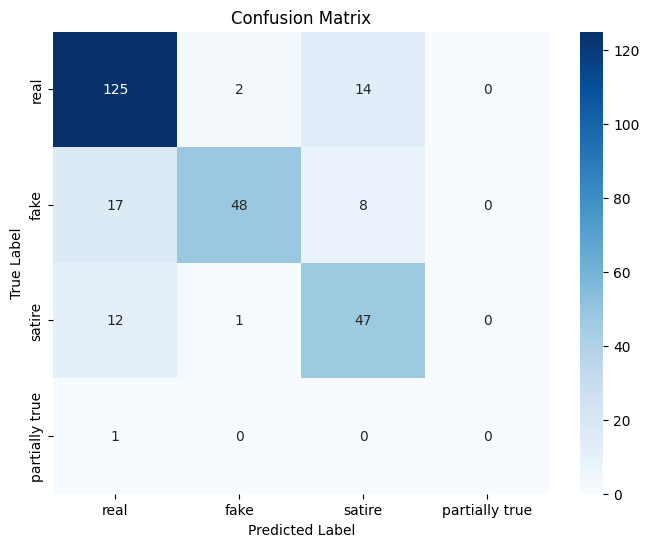

In [ ]:
# Class index to name map
idx2label = {v: k for k, v in LABEL_MAP.items()}

print("\n Classification Report:")
# Use classification_report and convert to DataFrame for better display
report = classification_report(all_labels, all_preds, target_names=idx2label.values(), output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

print("\n Confusion Matrix:")
# Use confusion_matrix and seaborn heatmap for better visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx2label.values(), yticklabels=idx2label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df = pd.DataFrame({
    "img_id": all_ids,
    "true_label": [idx2label[i] for i in all_labels],
    "predicted_label": [idx2label[i] for i in all_preds]
})

df.to_csv("test_predictions.csv", index=False)
print("✅ Saved test predictions to 'test_predictions.csv'")


✅ Saved test predictions to 'test_predictions.csv'


In [ ]:
df.head()

,img_id,true_label,predicted_label
0,259,real,real
1,274,real,real
2,1462,satire,satire
3,2866,fake,fake
4,276,real,real


In [ ]:
import os
import zipfile

# Define the directory to zip
directory_to_zip = '/content/wandb'
output_zip_file = 'wandb.zip'

# Create a ZipFile object
with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory and add all files to the zip file
    for root, dirs, files_list in os.walk(directory_to_zip):
        for file in files_list:
            # Create the full path to the file
            file_path = os.path.join(root, file)
            # Add the file to the zip file, preserving the directory structure
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f"Successfully created {output_zip_file}")

Successfully created wandb.zip
